# Générer des Tags de manière supervisée et non-supervisée

Pour générer des Tags de manière non-supervisé :
  - j'ai opéré une réduction des dimmensions avec une LDA.
  - j'attribue à chaque question les tags les plus utilisés dans les topics (du LDA) associés à la question.
  - j'ai créer un API qui permet de prédire les Tags associés au titre et au texte d'une question proposée.



Pour générer des Tags de manière supervisé :
  - j'ai créé des variables binaires pour les tags les plus fréquemment utilisés.
  - j'utilise des régressions logistique pour prédire si chaque Tag est associé à la question, en utilisant les features du text comme regresseurs.
  - j'ai créer un API qui permet de prédire les Tags associés au titre et au texte d'une question proposée.

## 1. Création de Bag of words

Importation des données

In [ ]:
# Import Data

import pandas as pd

Data = pd.read_csv('/QueryResults.csv', sep=',', engine='python', error_bad_lines=False)

Dans le contenu des questions, sélection du texte (tout ce qui est entre < p >...< /p >).

Mise en liste des différents textes: un texte pour chaque question.

Cleaning des questions:
  - Suppression des liens URL
  - Suppression du code
  - Suppression des caractères de mise en forme (gras, italique...)

On obtient un texte "propre" pour chaque question posée. Sauvegarde dans une variable sous le nom de 'Clean_Body'.


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

# Create a list of all Sentences

ParagraphBeginning = []
ParagraphEnd = []
Line = []

for i in range(len(Data)):
  Beginning = []
  End = []
  for h in range(len(Data['Body'].iloc[i])):
    if (Data['Body'].iloc[i][h:h+3]) == '<p>':
      Beginning.append(h+3)
    if (Data['Body'].iloc[i][h:h+4]) == '</p>':
      End.append(h)
  if (Beginning ==  []) or (End ==  []):
    Line.append(i)
    ParagraphBeginning.append([])
    ParagraphEnd.append([])
  if (len(Beginning) > len(End)) & (len(End) > 0):
    Gap = len(End) - len(Beginning)
    Line.append(i)
    ParagraphBeginning.append(Beginning[0:Gap])
    ParagraphEnd.append(End)
  if (len(Beginning) < len(End)) & (len(Beginning) > 0):
    Gap = len(Beginning) - len(End)
    Line.append(i)
    ParagraphBeginning.append(Beginning)
    ParagraphEnd.append(End[0:Gap])
  if (len(Beginning) == len(End)) & (len(Beginning) > 0):
    Line.append(i)
    ParagraphBeginning.append(Beginning)
    ParagraphEnd.append(End)
  if len(ParagraphBeginning) > i+1:
    break

Sentences = []

for i in range(len(ParagraphBeginning)):
  if ParagraphBeginning[i] == []:
    Bla = Data['Body'].iloc[i]
  if ParagraphBeginning[i] != []:
    Bla = Data['Body'].iloc[i][ParagraphBeginning[i][0]:ParagraphEnd[i][0]]
    if len(ParagraphBeginning[i]) > 1:
      for j in range(1,min(len(ParagraphBeginning[i]), len(ParagraphEnd[i]))):
        Bla = Bla + Data['Body'].iloc[i][ParagraphBeginning[i][j]:ParagraphEnd[i][j]]
  Sentences.append(Bla)


# Remove All the Links from the Sentences

LinkBeginning = []
LinkEnd = []

for i in range(len(Sentences)):
  Beginning = []
  End = []
  for h in range(len(Sentences[i])):
    if (Sentences[i][h:h+8]) == '<a href=':
      Beginning.append(h)
    if (Sentences[i][h:h+4]) == '</a>':
      End.append(h+4)
  LinkBeginning.append(Beginning)
  LinkEnd.append(End)

for i in range(len(Sentences)):
  if LinkBeginning[i] != []:
    Bla = Sentences[i].replace(Sentences[i][LinkBeginning[i][0]:LinkEnd[i][0]], '')
    if len(LinkBeginning[i]) > 0:
      for j in range(1,len(LinkBeginning[i])):
        Bla = Bla.replace(Sentences[i][LinkBeginning[i][j]:LinkEnd[i][j]], '')
    Sentences[i] = Bla


# Remove All the Code from the Sentences

CodeBeginning = []
CodeEnd = []

for i in range(len(Sentences)):
  Beginning = []
  End = []
  for h in range(len(Sentences[i])):
    if (Sentences[i][h:h+6]) == '<code>':
      Beginning.append(h)
    if (Sentences[i][h:h+7]) == '</code>':
      End.append(h+7)
  CodeBeginning.append(Beginning)
  CodeEnd.append(End)
  if len(CodeBeginning[-1]) > len(CodeEnd[-1]):
    Gap = len(CodeEnd) - len(CodeBeginning)
    CodeBeginning[-1] = Beginning[0:Gap]
  if len(CodeBeginning[-1]) < len(CodeEnd[-1]):
    Gap = len(CodeBeginning) - len(CodeEnd)
    CodeEnd[-1] = End[0:Gap]


for i in range(len(Sentences)):
  if (CodeBeginning[i] != []) & (CodeEnd[i] != []):
    if (CodeBeginning[i][0] < CodeEnd[i][0]) :
      Bla = Sentences[i].replace(Sentences[i][CodeBeginning[i][0]:CodeEnd[i][0]], '')
    if len(CodeBeginning[i]) > 0:
      for j in range(1,len(CodeBeginning[i])):
        if (CodeBeginning[i][j] < CodeEnd[i][j]) :
          Bla = Bla.replace(Sentences[i][CodeBeginning[i][j]:CodeEnd[i][j]], '')
    Sentences[i] = Bla


# Remove the <strong> from the Sentences

StrongBeginning = []
StrongEnd = []

for i in range(len(Sentences)):
  Beginning = []
  End = []
  for h in range(len(Sentences[i])):
    if (Sentences[i][h:h+8]) == '<strong>':
      Beginning.append(h)
      End.append(h+8)
    if (Sentences[i][h:h+9]) == '</strong>':
      Beginning.append(h)
      End.append(h+9)
  StrongBeginning.append(Beginning)
  StrongEnd.append(End)


for i in range(len(Sentences)):
  if StrongBeginning[i] != []:
    Bla = Sentences[i].replace(Sentences[i][StrongBeginning[i][0]:StrongEnd[i][0]], '')
    if len(StrongBeginning[i]) > 0:
      for j in range(1,len(StrongBeginning[i])):
        Bla = Bla.replace(Sentences[i][StrongBeginning[i][j]:StrongEnd[i][j]], '')
    Sentences[i] = Bla




# Remove the <em> from the Sentences

EmBeginning = []
EmEnd = []

for i in range(len(Sentences)):
  Beginning = []
  End = []
  for h in range(len(Sentences[i])):
    if (Sentences[i][h:h+4]) == '<em>':
      Beginning.append(h)
      End.append(h+4)
    if (Sentences[i][h:h+5]) == '</em>':
      Beginning.append(h)
      End.append(h+5)
  EmBeginning.append(Beginning)
  EmEnd.append(End)


for i in range(len(Sentences)):
  if EmBeginning[i] != []:
    Bla = Sentences[i].replace(Sentences[i][EmBeginning[i][0]:EmEnd[i][0]], '')
    if len(EmBeginning[i]) > 0:
      for j in range(1,len(EmBeginning[i])):
        Bla = Bla.replace(Sentences[i][EmBeginning[i][j]:EmEnd[i][j]], '')
    Sentences[i] = Bla




# Remove the <s> from the Sentences

SBeginning = []
SEnd = []

for i in range(len(Sentences)):
  Beginning = []
  End = []
  for h in range(len(Sentences[i])):
    if (Sentences[i][h:h+3]) == '<s>':
      Beginning.append(h)
      End.append(h+3)
    if (Sentences[i][h:h+4]) == '</s>':
      Beginning.append(h)
      End.append(h+4)
  SBeginning.append(Beginning)
  SEnd.append(End)


for i in range(len(Sentences)):
  if SBeginning[i] != []:
    Bla = Sentences[i].replace(Sentences[i][SBeginning[i][0]:SEnd[i][0]], '')
    if len(SBeginning[i]) > 0:
      for j in range(1,len(SBeginning[i])):
        Bla = Bla.replace(Sentences[i][SBeginning[i][j]:SEnd[i][j]], '')
    Sentences[i] = Bla

# Add the Cleaned Body to the DataBase

Data['Clean_Body'] = pd.DataFrame(Sentences, columns=["Clean_Body"])

# Export Database

Data.to_csv('/content/QueryResults_Clean.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Les étapes de "cleaning" des textes est assez long. Donc une fois la variable 'Clean_Body" créée, je sauvegarde la base de données sous le nom de 'QueryResults_Clean.csv'.

Puis je la ré-importe ci-dessous.

In [101]:
# Import Data with Clean Sentences

import pandas as pd

Data = pd.read_csv('/QueryResults_Clean.csv', sep=',', engine='python')

Je créer une nouvelle fonction qui prépare le texte avant la mise en Bag of Words.
Cette fonction - TextCleaning() - supprime les chiffres, et les caractères pouvant poser problème (_,;[]<>@...).

Je créer une seconde fonction - BaggingText() - qui "tokenize" puis "Lematize" le texte propre, et qui le retourne sous forme de Bag of Words.

In [102]:
# Define Text Cleaning function which eliminates punctuation and figures

def TextCleaning(Text):
  Text = str(Text)
  Text = Text.replace('_', ' ')
  Text = Text.replace('-', ' ')
  Text = Text.replace('+', ' ')
  Text = Text.replace("'", ' ')
  Text = Text.replace('"', '')
  Text = Text.replace('”', '')
  Text = Text.replace('(', '')
  Text = Text.replace(')', '')
  Text = Text.replace('[', '')
  Text = Text.replace(']', '')
  Text = Text.replace('{', '')
  Text = Text.replace('}', '')
  Text = Text.replace('>', ' ')
  Text = Text.replace('<', ' ')
  Text = Text.replace('@', '')
  Text = Text.replace('|', '')
  Text = Text.replace('/', '')
  Text = Text.replace('"', '')
  Text = Text.replace('=', '')
  Text = Text.replace('.', '')
  Text = Text.replace(',', '')
  Text = Text.replace(':', '')
  Text = Text.replace('!', '')
  Text = Text.replace('?', '')
  Text = Text.replace('0', '')
  Text = Text.replace('1', '')
  Text = Text.replace('2', '')
  Text = Text.replace('3', '')
  Text = Text.replace('4', '')
  Text = Text.replace('5', '')
  Text = Text.replace('6', '')
  Text = Text.replace('7', '')
  Text = Text.replace('8', '')
  Text = Text.replace('9', '')
  Text = Text.replace(' p ', '')
  return Text


# Define Bagging function which transforms text into a clean bag of words

import nltk
nltk.download('punkt')
nltk.download('wordnet')

def BaggingText(Text):

  # Tokenize text

  Bag = nltk.word_tokenize(Text)

  # Make the words cleaner

  lemma = nltk.wordnet.WordNetLemmatizer()

  for i in range(0,len(Bag)):
    Bag[i] = Bag[i].lower()
    Bag[i] = lemma.lemmatize(Bag[i])

  return Bag

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Afin d'extraire les features de Stacks Overflow, je fais une concatenation de tous les textes contenu dans les questions, et je créé un "MetaText" qui fusionne tous les textes.

Je fais de même pour tous les titres des questions, en crééant un "MetaTitle".

Enfin, je créér un Bag of Words pour le MetaTexte, puis de même pour le MetaTitle. Ces deux Bag of Words me permettront d'extraire les features de Stacks Overflow.


Enfin je met le texte et le titre de chaque question, dans des bags of words, que je sauvegarde respectivement dans les variables 'Bags' et 'Title_Bags'.

In [103]:
# Concatenate all 'Clean_Body' sentences into a huge text: MetaText

MetaText = str(Data['Clean_Body'].iloc[0])

for i in range(1, len(Data)):
  MetaText = MetaText + ' ' + str(Data['Clean_Body'].iloc[i])
  if i%10000 == 0:
    print(i)

# Clean MetaText and then put words into Bag

MetaText = TextCleaning(MetaText)

MetaBag = BaggingText(MetaText)


# Clean Text of each individual and put words into Bag then store in variable

Data['Bags'] = Data.apply(lambda row:  TextCleaning(row['Clean_Body']), axis=1)
Data['Bags'] = Data.apply(lambda row:  BaggingText(row['Bags']), axis=1)







# Concatenate all 'Titles' into a huge text: MetaTitle

MetaTitle = str(Data['Title'].iloc[0])

for i in range(1, len(Data)):
  MetaTitle = MetaTitle + ' ' + str(Data['Title'].iloc[i])
  if i%10000 == 0:
    print(i)

# Clean MetaText and then put words into Bag

MetaTitle = TextCleaning(MetaTitle)

TitleBag = BaggingText(MetaTitle)


# Clean Text of each individual and put words into Bag then store in variable

Data['Title_Bag'] = Data.apply(lambda row:  TextCleaning(row['Title']), axis=1)
Data['Title_Bag'] = Data.apply(lambda row:  BaggingText(row['Title_Bag']), axis=1)

10000
20000
30000
40000
10000
20000
30000
40000


Ci-dessous je montre les mots les plus fréquents dans les textes et dans les titres des questions de Stacks Overflow.

(On remarquera la grande fréquence de stop words).

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


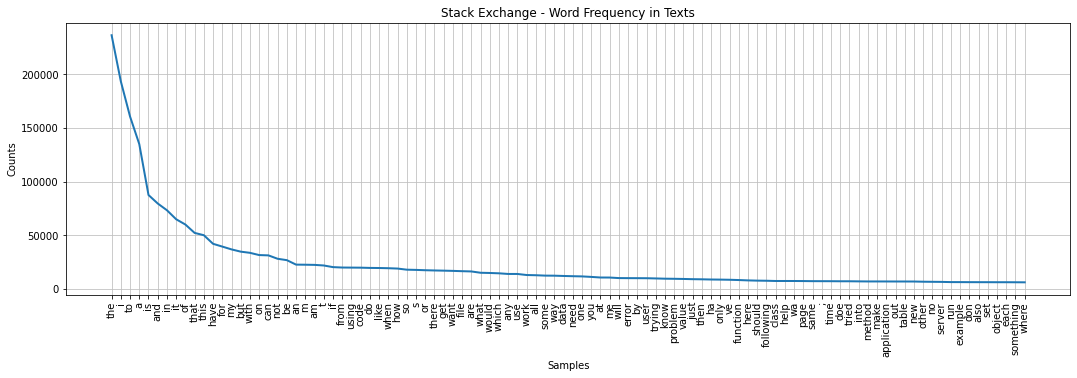

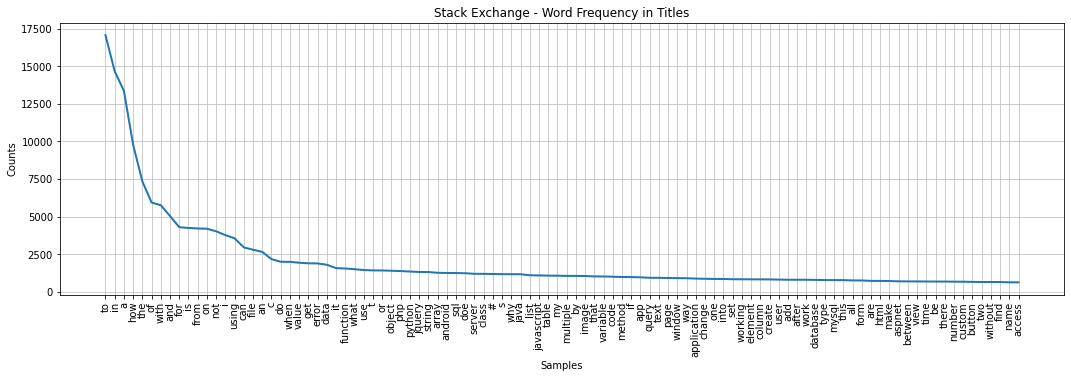

In [104]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import FreqDist

# Plot Frequency of words in the MetaBag

import matplotlib.pyplot as plt
plt.figure(figsize=(18,5))

Meta_fdist = nltk.FreqDist(MetaBag)
Meta_Words = list(Meta_fdist.keys())
Meta_Freq = list(Meta_fdist.values())

zipped_lists = zip(Meta_Freq, Meta_Words)
sorted_pairs = sorted(zipped_lists, reverse=True)
tuples = zip(*sorted_pairs)   
Meta_Freq, Meta_Words = [list(tuple) for tuple in  tuples]

Meta_fdist.plot(100, cumulative=False, title="Stack Exchange - Word Frequency in Texts")


# Plot Frequency of words in the TitleBag

plt.figure(figsize=(18,5))

Title_fdist = nltk.FreqDist(TitleBag)
Title_Words = list(Title_fdist.keys())
Title_Freq = list(Title_fdist.values())

zipped_lists = zip(Title_Freq, Title_Words)
sorted_pairs = sorted(zipped_lists, reverse=True)
tuples = zip(*sorted_pairs)   
Title_Freq, Title_Words = [list(tuple) for tuple in  tuples]

Title_fdist.plot(100, cumulative=False, title="Stack Exchange - Word Frequency in Titles")

Etant donné que les mots les plus fréquents dans les questions (aussi bien dans les titres que dans les textes) sont des Stop Words (the, i, in, a,...), je supprime les stops words dans les bags of words du MetaText et du MetaTitle.

In [105]:
# Remove Stop Words - Text

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

Words = []
Freq = []

for i in range(len(Meta_Words)):
  if Meta_Words[i] not in stopwords.words('english'):
    Words.append(Meta_Words[i])
    Freq.append(Meta_Freq[i])

Meta_Words = Words
Meta_Freq = Freq

# Remove Stop Words - Title

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

Words = []
Freq = []

for i in range(len(Title_Words)):
  if Title_Words[i] not in stopwords.words('english'):
    Words.append(Title_Words[i])
    Freq.append(Title_Freq[i])

Title_Words = Words[1::]
Title_Freq = Freq[1::]

print(' ')
print('Text')
print(Meta_Words[0:300])
print(Meta_Freq[0:300])

print(' ')
print('Title')
print(Title_Words[0:300])
print(Title_Freq[0:300])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
 
Text
['using', 'code', 'like', 'get', 'want', 'file', 'would', 'use', 'work', 'way', 'data', 'need', 'one', 'error', 'user', 'trying', 'know', 'problem', 'value', 'ha', 'function', 'following', 'help', 'class', 'wa', 'page', ';', 'time', 'tried', 'doe', 'method', 'make', 'application', 'table', 'new', 'server', 'run', 'example', 'also', 'set', 'object', 'something', 'app', 'image', 'see', 'first', 'create', 'br', 'change', 'working', 'could', 'find', 'list', 'question', 'line', 'add', 'call', 'two', 'project', 'c', 'type', 'database', 'look', 'number', 'name', 'possible', 'return', 'string', 'button', 'text', 'show', 'able', 'different', 'however', 'result', 'view', 'window', 'used', 'query', 'column', 'array', 'form', 'anyone', 'getting', 'another',

Après avoir supprimé les stop words, je ne garde que les 500 mots les plus fréquents du MetaText et du MetaTitle.


In [ ]:
# Keep only the 500 most frequent words from the Text

Meta_Words = Meta_Words[0:500]
Meta_Freq = Meta_Freq[0:500]


# Keep only the 500 most frequent words from the Title

Title_Words = Title_Words[0:500]
Title_Freq = Title_Freq[0:500]


Pour chaque question, je ne garde que les mots qui sont dans les 500 les plus fréquemment utilisés dans les titres des question.

Ces 500 mots sont donc mes features, qui me permettront de classer les questions.

Après n'avoir gardé que les 500 mots les plus représentés dans le MetaTitle, je fais pour chaque question une concatenation du bag of words des titres, avec le bag of words du texte qui leur correspond. 

J'ai donc un unique bag of words correspondant au titre et au texte pour chaque question, que je sauvegarde dans une variable nommée 'Clean_Bags'.

Je sauvegarde la base de données, car les étapes précédentes sont longues.

In [ ]:
# For each question's Bag of words, remove words which are not in the top 500 words of the MetaTitle bag of words

Data['Clean_Bags'] = 0

for i in range(len(Data)):
  Individual_Bag = []
  for j in range(len(Data['Bags'].iloc[i])):
    if (Data['Bags'].iloc[i][j] in Title_Words):
      Individual_Bag.append(Data['Bags'].iloc[i][j])
  for h in range(len(Data['Title_Bag'].iloc[i])):
    if (Data['Title_Bag'].iloc[i][h] in Title_Words):
      Individual_Bag.append(Data['Title_Bag'].iloc[i][h])
  Data['Clean_Bags'].iloc[i] = Individual_Bag
  if i%10000 == 0:
    print(i)

# Export Database

Data.to_csv('/QueryResults_Clean2.csv')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0
10000
20000
30000
40000


Je "plot" ci-dessous les mots les plus fréquents dans le texte et dans le titre des questions, après avoir supprimé les stopwords.

Les features que j'utilise dorénavant sont les 500 mots les plus utilisés dans les titres (second graphe)

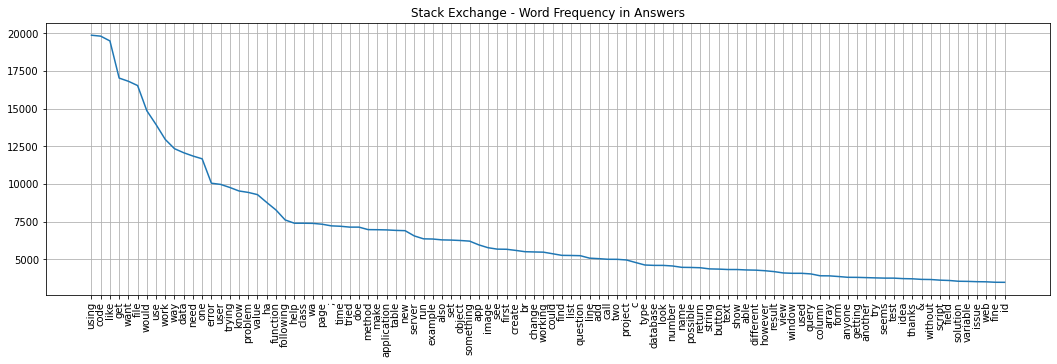

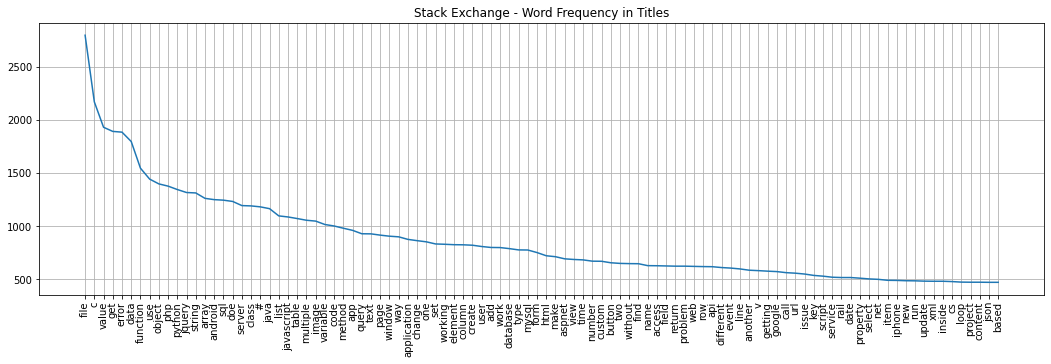

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))

plt.plot(Meta_Words[0:100], Meta_Freq[0:100])
plt.grid(True)
plt.title("Stack Exchange - Word Frequency in Answers")
plt.xticks(rotation=90)
plt.show()


import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))

plt.plot(Title_Words[0:100], Title_Freq[0:100])
plt.grid(True)
plt.title("Stack Exchange - Word Frequency in Titles")
plt.xticks(rotation=90)
plt.show()

## 2. Génération Non-supervisée de Tags

Importation de la base données avec les bags of words contenant  seulement les mots des 500 features.

In [106]:
# Import Data

import pandas as pd

Data = pd.read_csv('/QueryResults_Clean2.csv', sep=',', engine='python', error_bad_lines=False)

Je fais un "count-vectorizer" pour compter le nombre de fois que chacune des 500 features est utilisée dans le texte ou dans le titre de chaque question.

Je sauvegarde les résultats dans une base de données intitulée "Count_Data".

In [107]:
# Count vectorizer

from sklearn.feature_extraction.text import CountVectorizer

Corpus = []

for i in range(len(Data)):
  Corpus.append(str(Data['Clean_Bags'].iloc[i]))

count_vectorizer = CountVectorizer(analyzer='word',stop_words= 'english')

X = count_vectorizer.fit_transform(Corpus)

  # Store Count vectorizer in a DataFrame

Count_Data = pd.DataFrame(data = X.toarray(),columns = count_vectorizer.get_feature_names())

Etant donné que mon count-vectorizer contient 500 dimensions, j'essaye de voir ci-dessous, si je peux opérer une réduction des dimensions avec une PCA.

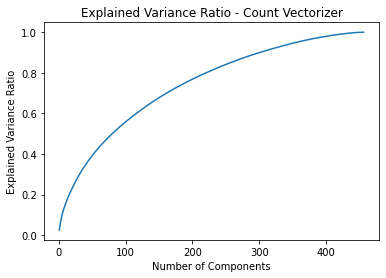

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing

X = Count_Data

min_max_scaler = preprocessing.MinMaxScaler()

X_scaled = min_max_scaler.fit_transform(X)

NB_Components = 456

pca = PCA(n_components=NB_Components)
pca.fit(X_scaled)

Components = range(1,NB_Components + 1)

Ratio = 0
Explained_Variance = []

for i in range(len(pca.explained_variance_ratio_)):
  Ratio = Ratio + pca.explained_variance_ratio_[i]
  Explained_Variance.append(Ratio)

plt.plot(Components, Explained_Variance)
plt.title('Explained Variance Ratio - Count Vectorizer')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

Le graphique ci-dessus montre la part de la variance totale qui peut-être expliquée, si l'on réduit le nombre de dimmensions avec une PCA.

On remarque par exemple qu'avec 100 dimensions, on peut expliquer un peu plus de 50% de la variance totale.

Pour attenteindre 90% de la variance totale, il faudrait environ 350 composantes sur les 500 variables d'origines.

Je pense donc qu'une PCA n'est pas optimale pour réduire le nombre de dimensions, car on risque d'expliquer une part trop faible de la variance.

A la place d'une PCA, je choisi donc d'utiliser un modèle de Latent Dirichlet Allocation (LDA), qui de toute façon est plus approprié dans le traitement des textes.

Je choisi de fixer 20 sujets sous-jacents (donc de réduire à 20 dimensions).

In [109]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

X = Count_Data

lda = LatentDirichletAllocation(n_components=20,
                                random_state=0)
lda.fit(X)

# get topics for some given samples:
Count_LDA =  lda.transform(X)

Count_LDA = pd.DataFrame(data = Count_LDA)

Ci-dessous, je montre les mots les plus fréquents dans chacun des 20 sujets identifiés par le LDA.

Topic #0:


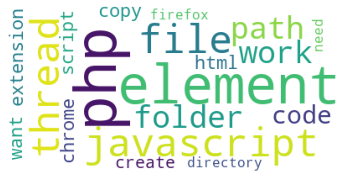



Topic #1:


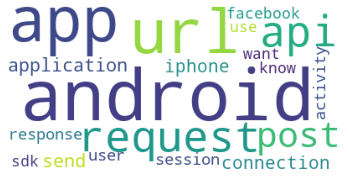



Topic #2:


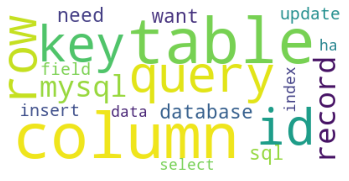



Topic #3:


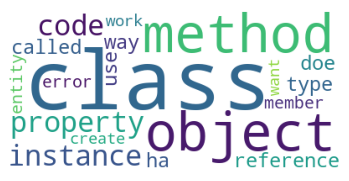



Topic #4:


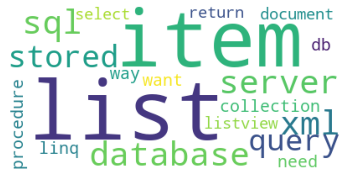



Topic #5:


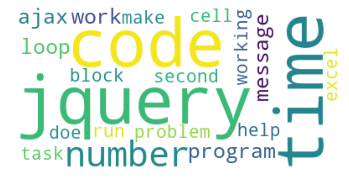



Topic #6:


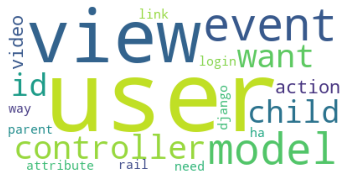



Topic #7:


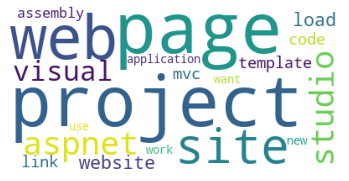



Topic #8:


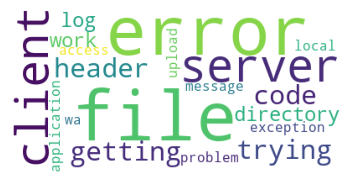



Topic #9:


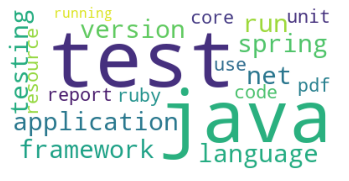



Topic #10:


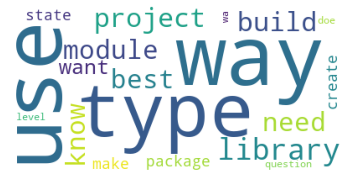



Topic #11:


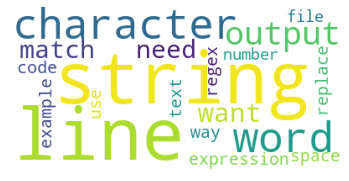



Topic #12:


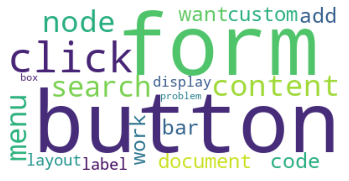



Topic #13:


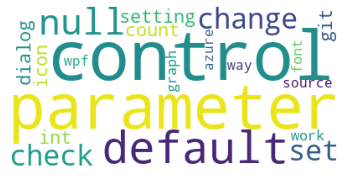



Topic #14:


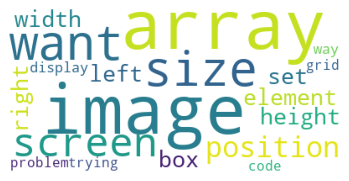



Topic #15:


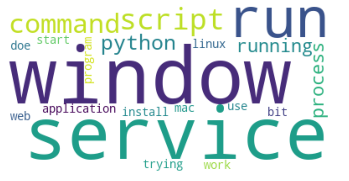



Topic #16:


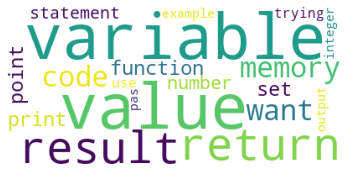



Topic #17:


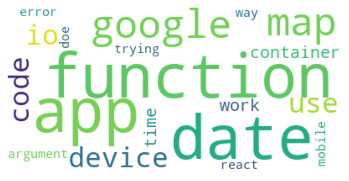



Topic #18:


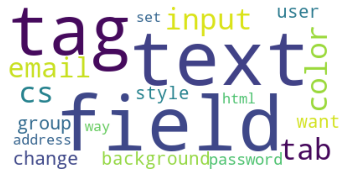



Topic #19:


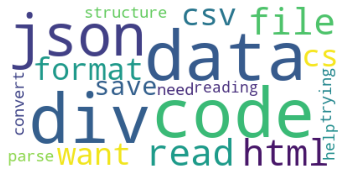

In [110]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


for i,topic in enumerate(lda.components_):
  print(f'Topic #{i}:')
  text = [count_vectorizer.get_feature_names()[i] for i in topic.argsort()[-20:]]
  bla = text[-1]
  for j in range(1,len(text)):
    bla = bla + ' ' + text[-j-1]
  wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(bla)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show();
  print('\n')

Pour évaluer les performances du LDA je divise les données en Trainning set et Test set.

In [111]:
# Separation des données en Test et Trainnning

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Shuffled_Data = shuffle(Count_Data)

X = Shuffled_Data

X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)

Unsupervised_train = X_train
Unsupervised_test = X_test

Ensuite je "fit" un LDA sur les données de Trainning, et je transforme les données Test avec.

Je compare les résultats obtenus si "fit" le LDA sur les données Test, et en transformant les données Test.

In [112]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

X = Unsupervised_train

lda_train = LatentDirichletAllocation(n_components=20,
                                random_state=0)
lda_train.fit(X)

# get topics for some given samples:
Train_LDA =  lda_train.transform(X)
Train_LDA = pd.DataFrame(data = Train_LDA)




from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

X = Unsupervised_test

lda_test = LatentDirichletAllocation(n_components=20,
                                random_state=0)
lda_test.fit(X)

# get topics for some given samples:
Test_LDA =  lda_test.transform(X)
Test_LDA = pd.DataFrame(data = Test_LDA)


# get topics for some given samples:
Test_LDA2 =  lda_train.transform(X)
Test_LDA2 = pd.DataFrame(data = Test_LDA2)

In [113]:
# Concatenate the LDA fitted on Test, to the LDA fitted on Train.

Double_Test_LDA = pd.concat([Test_LDA, Test_LDA2], axis=1)

# Map the 20 topics to one another, when fitted on Training set and Test set

First_Topics = []
Second_Topics = []

for i in range(len(Test_LDA.columns)):
  First_Topics.append(i)
  Similarity = []
  for j in range(len(Test_LDA2.columns)):
    z = len(Test_LDA.columns) + j
    Bla = abs(Double_Test_LDA.iloc[:,i] - Double_Test_LDA.iloc[:,z])
    Similarity.append(Bla.sum())
  Smallest = Similarity[0]
  Match = 0
  for h in range(len(Test_LDA2.columns)):
    if Similarity[h] < Smallest:
      Smallest = Similarity[h]
      Match = h
  Second_Topics.append(Match)

# Compute R2 for between identical topics

R2 = []

for i in range(len(Test_LDA.columns)):
  Top = ((Double_Test_LDA.iloc[:,i] - Double_Test_LDA.iloc[:,len(Test_LDA.columns) + Second_Topics[i]])**2).sum()
  Bottom = ((Double_Test_LDA.iloc[:,i] - np.mean(Double_Test_LDA.iloc[:,i]))**2).sum()
  R2.append(round(1 - (Top / Bottom), 3))


zipped_lists = zip(R2, First_Topics)
sorted_pairs = sorted(zipped_lists, reverse=True)
tuples = zip(*sorted_pairs)

R2, First_Topics = [list(tuple) for tuple in  tuples]


print('Topics')
print(First_Topics)

print(' ')
print('Similarités entre les topics dans les données Test, si je "fit" le LDA sur les données Test ou si je "fit" le LDA sur les données Trainning - R2')
print(R2)

Topics
[3, 2, 19, 4, 7, 16, 10, 17, 6, 12, 8, 9, 1, 14, 5, 0, 15, 18, 13, 11]
 
Similarités entre les topics dans les données Test, si je "fit" le LDA sur les données Test ou si je "fit" le LDA sur les données Trainning - R2
[0.809, 0.785, 0.773, 0.639, 0.626, 0.58, 0.554, 0.378, 0.371, 0.351, 0.343, 0.237, 0.215, 0.163, 0.145, -0.017, -0.028, -0.089, -0.151, -0.453]


On remarque que certains topics (2,4,14,...) sont correctement identifiés dans les données Test, en fittant sur les données Test, ou les données Training.

A l'inverse, d'autres topics (...,0, 3, 18) sont mal identifiés, en fittant sur les données Training et en transformant sur les données Test.

2 explications possibles:
  - Overfitting de certains topics sur les données training (topic identifiés dans les données training, mais ne reflétant pas un topic réllement sous-jacent dans Stack Overflow).
  - Certains topics sont peut-être trop génériques, pas suffisamment distincts des autres, et par conséquent ces topics ne sont pas retrouvés en fittant le LDA sur les données test.

Une possibilité serait d'accroître significativement le nombre de topics dans le LDA, ce qui aurait pour effet de rendre les topics très précis. Puis on ne garderait que les topic correctement identifiés sur les données Test. En revanche, je ne pourrais pas faire cela ici, car le temps de calcul serait très long.

Ci-dessous, je défini une fonction qui compte dans un texte et dans son titre le nombre de fois que chaque mot des 500 features a été utilisé.

In [114]:
# Define function that maps Question to LDA space

def Map_to_Vectorizer(Text, Title):
  CleanText = TextCleaning(Text)
  CleanText = BaggingText(CleanText)
  CleanTitle = TextCleaning(Title)
  CleanTitle = BaggingText(CleanTitle)
  Bag = []
  for i in range(len(CleanText)):
    if CleanText[i] not in stopwords.words('english'):
      Bag.append(CleanText[i])
  for j in range(len(CleanTitle)):
    if CleanTitle[j] not in stopwords.words('english'):
      Bag.append(CleanTitle[j])
  Count = []
  for h in range(len(list(Count_Data.columns)[0:456])):
    Count.append(Bag.count(list(Count_Data.columns)[h]))
  Number = []
  Number.append(Count)
  return Number, Bag

Je definis ensuite une fonction qui "map" le count-vectorizer d'un texte (quel qu'il soit) dans le LDA qui a prélablement été "fitté" sur l'ensemble des questions.

Dans un second temps, cette fonction renvoient les mots qui correspondent aux "Topics" du text (tels que définis dans le LDA), à condition que ces mots soient inclus dans ce texte.

In [115]:
def Unsupervised_Tagger(Title, Text):
  Test, Test_Bag = Map_to_Vectorizer(Title, Text)
  Test_Data = pd.DataFrame(data = Test,columns = Count_Data.columns)
  print(Test_Data)
  X = Test_Data
  Test_LDA =  lda.transform(X)
  Test_LDA = pd.DataFrame(data = Test_LDA)
  print(Test_LDA)
  zipped_lists = zip(list(Test_LDA.iloc[0]), list(Test_LDA.columns))
  sorted_pairs = sorted(zipped_lists, reverse=True)
  tuples = zip(*sorted_pairs)

  LDA, Categories = [list(tuple) for tuple in  tuples]

  print(LDA)
  print(Categories)

  Tags = []

  for i,topic in enumerate(lda.components_):
    if (i == Categories[0]) & (LDA[0] > 0.9):
      bla = [count_vectorizer.get_feature_names()[i] for i in topic.argsort()[-3:]]
      print(bla)
      for j in range(len(bla)):
          Tags.append(bla[-j-1])
    for h in range(0,3):
      if (i == Categories[h]) & (LDA[h] > 0.3):
        bla = [count_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]]
        for j in range(len(bla)):
          if bla[-j-1] in Test_Bag:
            print(bla[-j-1])
            Tags.append(bla[-j-1])

  Tags = list(set(Tags))

  return Tags

Ci-dessous je créé une API dans laquelle on peut écrire un titre et une question, et cette API renvoit de manière non-supervisée  les labels associés à cette questions (en utilisant la fonction Unsupervised_Tagger() définie ci-dessus).

In [116]:
pip install gradio

     |████████████████████████████████| 1.3MB 14.9MB/s 
     |████████████████████████████████| 1.9MB 52.7MB/s 
     |████████████████████████████████| 215kB 44.9MB/s 
     |████████████████████████████████| 3.2MB 42.6MB/s 
     |████████████████████████████████| 962kB 40.1MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-cp37-none-any.whl size=3372 sha256=f005d2b1a228c8391b3cb8b434629eb7980b0119bb5ef91f4a70d2776bae775a
  Stored in directory: /root/.cache/pip/wheels/9f/fc/a7/ab5712c3ace9a8f97276465cc2937316ab8063c1fea488ea77
  Created wheel for ffmpy: filename=ffmpy-0.3.0-cp37-none-any.whl size=4710 sha256=2fd14a19f3008bdc24977e7514b2f8a4fad52f9888969a3661c48cf08bfdecec
  Stored in directory: /root/.cache/pip/wheels/cc/ac/c4/bef572cb7e52bfca170046f567e64858632daf77e0f34e5a74
Successfully built flask-cachebuster ffmpy


In [117]:
import gradio as gr

gr.Interface(fn=Unsupervised_Tagger, title="Generating Tags - Unsupervised", description="Cette API génère des tags en 'mappant' le texte dans l'espace des 20 topics générés par le modèle de Latent Dirichlet Allocation (LDA), paramétré sur 50.000 questions de Stack Overflow.", inputs=["text","textbox"], outputs="textbox").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://48575.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://48575.gradio.app')

## 3. Tagging Supervisé

Dans cette partie je créé une base de données contenant les 500 mots que j'ai choisi comme features dans la partie 2, à laquelle j'ajoute des variables binaires pour chaque Tag.

Je prédis si la question a été associée à chaque Tag, en utilisant une régression logistique avec les 500 features comme prédicteurs.

Ci-dessous, j'utilise la variable 'Tags' pour créer un bag of words contenant pour chaque question les tags fournis dans la base de données.

In [11]:
# Create list with all "real" tags and create list of all tags for each individual

Data['Tag_Bags'] = 0

Tags = []

for i in range(len(Data)):
  Personal_Tags = []
  for h in range(len(Data['Tags'].iloc[i])):
    if Data['Tags'].iloc[i][h] == '<':
      Beginning = h+1
      for k in range(h, len(Data['Tags'].iloc[i])):
        if Data['Tags'].iloc[i][k] == '>':
          End = k
          Personal_Tags.append(Data['Tags'].iloc[i][Beginning:End])
          Tags.append(Data['Tags'].iloc[i][Beginning:End])
          break
  Data['Tag_Bags'].iloc[i] = Personal_Tags

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


J'ordonne tous les tags par ordre décroissant de fréquence.

Je garde seulement les Tags utilisés plus de 100 fois.

In [12]:
# Reorder all Tags by frequency

UniqueTags = list(set(Tags))
Number = []

for i in range(len(UniqueTags)):
  Number.append(Tags.count(UniqueTags[i]))

zipped_lists = zip(Number, UniqueTags)
sorted_pairs = sorted(zipped_lists, reverse=True)
tuples = zip(*sorted_pairs)   
Number, UniqueTags = [list(tuple) for tuple in  tuples]

# Store all tags that appear at least 100 times

TopTags = UniqueTags[0:187]

Pour chaque question, je ne garde que les tags utilisés plus de 100 fois en tout.

In [13]:
Data['Clean_Tags'] = 0

for i in range(len(Data)):
  Individual_Bag = []
  for j in range(len(Data['Tag_Bags'].iloc[i])):
    if (Data['Tag_Bags'].iloc[i][j] in TopTags):
      Individual_Bag.append(Data['Tag_Bags'].iloc[i][j])
  Data['Clean_Tags'].iloc[i] = Individual_Bag

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Je fais un Count-Vectorizer pour compter le nombre de fois que chaque tag a été utilisé dans chaque question. Si un Tag est utilisé plus de 1 fois (ce serait une erreur) par question, je remplace le nombre de fois par un 1.

Je génère donc une variable binaire pour chaque Tag, indiquant si chaque question est associé à ce Tag.

Je sauvegarde toutes les variables binaires pour chaque Tag dans une base de données appelée "Targets_Data".

In [14]:
# Count vectorizer

from sklearn.feature_extraction.text import CountVectorizer

Corpus = []

for i in range(len(Data)):
  Corpus.append(str(Data['Clean_Tags'].iloc[i]))

count_vectorizer = CountVectorizer(analyzer='word',stop_words= 'english')
X = count_vectorizer.fit_transform(Corpus)

  # Store Count vectorizer in a DataFrame

Targets_Data = pd.DataFrame(data = X.toarray(),columns = count_vectorizer.get_feature_names())

  # Replace all Counts by a Binary

for i in range(len(Targets_Data.columns)):
  VariableName = str(Targets_Data.columns[i])
  Targets_Data[VariableName][Targets_Data[VariableName] > 0] = 1

Ci-dessous, je fusionne les bases de données avec l'utilisation de chaque features pour chaque question (Count_Data), avec la base de données contenant les variables binaires pour chaque Tag (Targets_Data).

J'obtients donc une base de données - nommée Supervised_Data - avec pour chaque question le nombre de fois que chacune des 500 features a été utilisée dans la question, et si chacun des tags a été associé à la question.


Je sépare enfin ces données en Train/Test.

In [15]:
# Fusion des 500 features avec les 200 variables targets

Count_Data = Count_Data.iloc[:,0:456]

Count_Data_Renamed = Count_Data

for i in range(len(Count_Data.columns)):
    Count_Data_Renamed[str(i)] = Count_Data.iloc[:,i]
    
Count_Data_Renamed = Count_Data_Renamed.iloc[:,456:912]

Supervised_Data = pd.concat([Count_Data_Renamed, Targets_Data], axis=1)

Count_Data = Count_Data.iloc[:,0:456]


# Separation des données en Test et Trainnning

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Shuffled_Data = shuffle(Supervised_Data)

X = Shuffled_Data.iloc[:,0:456]
y = Shuffled_Data.iloc[:,456::]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Supervised_train = pd.concat([X_train, y_train], axis=1)
Supervised_test = pd.concat([X_test, y_test], axis=1)

Je "fit" une regression logistique sur les 500 features, une fois pour chaque variable binaire de Tag, et je sauvegarde les modèles fittés dans un dictionaire nommé Models.

In [ ]:
# Fit 200 logistic regressions - one for each Tag - on the 500 features, and store in dictionary

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

X = Supervised_train.iloc[:,0:456]

LogitModels = {}
LogitReg = {}
for i in range(456,len(Supervised_Data.columns)):
    LogitReg["Logit_{0}".format(i)] = LogisticRegression(random_state=0)
    y = Supervised_train.iloc[:,i]
    LogitModels["model_{0}".format(i)] = LogitReg["Logit_{0}".format(i)].fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
# Evaluating the performances of the Logistic Regressions to predict Tag

Names = []
Sensitivity = []
Specificity = []
Precision = []
NegativePrecision = []
Accuracy = []

for i in range(456,len(Supervised_train.columns)):
  Names.append(str(Supervised_test.columns[i]))
  VariableName = "Predicted_" + str(Supervised_test.columns[i])
  Supervised_test[VariableName] = LogitReg["Logit_{0}".format(i)].predict(Supervised_test.iloc[:,:456])
  Supervised_test[VariableName][Supervised_test[VariableName] > 0.7] = 1
  bla1 = Supervised_test[str(Supervised_test.columns[i])][Supervised_test[VariableName] == 1].mean()
  bla2 = Supervised_test[VariableName][Supervised_test[str(Supervised_test.columns[i])] == 1].mean()
  bla3 = 1 - Supervised_test[str(Supervised_test.columns[i])][Supervised_test[VariableName] == 0].mean()
  bla4 = 1 - Supervised_test[VariableName][Supervised_test[str(Supervised_test.columns[i])] == 0].mean()
  True_Positives = len(Supervised_test[(Supervised_test[str(Supervised_test.columns[i])] == 1) & (Supervised_test[VariableName] == 1)])
  True_Negatives = len(Supervised_test[(Supervised_test[str(Supervised_test.columns[i])] == 0) & (Supervised_test[VariableName] == 0)])
  False_Positives = len(Supervised_test[(Supervised_test[str(Supervised_test.columns[i])] == 1) & (Supervised_test[VariableName] == 0)])
  False_Negatives = len(Supervised_test[(Supervised_test[str(Supervised_test.columns[i])] == 0) & (Supervised_test[VariableName] == 1)])
  Sensitivity.append(round(bla1, 4))
  Specificity.append(round(bla3, 4))
  Precision.append(round(bla2, 4))
  NegativePrecision.append(round(bla4, 4))
  Accuracy.append(round((True_Positives+True_Negatives)/(True_Positives+True_Negatives+False_Positives+False_Negatives),4))

zipped_lists = zip(Accuracy, Sensitivity, Specificity, Precision, NegativePrecision, Names)
sorted_pairs = sorted(zipped_lists, reverse=True)
tuples = zip(*sorted_pairs)   
Accuracy, Sensitivity, Specificity, Precision, NegativePrecision, Names = [list(tuple) for tuple in  tuples]

print('Names')
print(Names)
print(' ')
print('Accuracy')
print(Accuracy)

print(' ')
print('Sensitivity')
print(Sensitivity)

print(' ')
print('Specificity')
print(Specificity)

print(' ')
print('Precision')
print(Precision)

Names
['docker', 'firebase', 'azure', 'drupal', 'matlab', 'data', 'core', 'sqlite', 'dictionary', 'batch', 'stored', 'procedures', 'silverlight', 'join', 'encryption', 'react', 'native', 'wcf', 'powershell', 'vim', 'networking', 'gcc', 'dom', 'perl', 'hibernate', 'maven', 'patterns', 'design', 'inheritance', 'xslt', 'audio', 'twitter', 'bootstrap', 'pdf', 'applications', 'math', 'search', 'jsf', 'caching', 'mongodb', 'firefox', 'pointers', 'exception', 'facebook', 'maps', 'htaccess', 'dataframe', 'git', 'pandas', 'chrome', 'laravel', 'sockets', 'flex', 'engine', 'app', 'numpy', 'tomcat', 'logging', 'ubuntu', 'reflection', 'symfony', 'sorting', 'email', 'authentication', 'generics', 'ms', 'access', 'selenium', 'internet', 'explorer', 'session', 'iis', 'parsing', 'optimization', 'csv', 'view', 'model', 'controller', 'events', 'ui', 'flash', 'listview', 'boot', 'ipad', 'object', 'uitableview', 'haskell', 'loops', 'jsp', 'validation', 'templates', 'amazon', 'unix', 'wordpress', 'rest', 'sv

Le score de Accuracy est très élevé (en partie parce qu'il y a de nombreux 0 sur les variables binaires).

On voit d'ailleurs avec la "Specificity" que la non-prédiction de chaque Tag, est bien réussie (le ratio de "true negatives" sur "false negatives+true negatives" est très elevé).

On voit avec la "Precision" que les regressions "sous-prédisent" souvent les tags (le ratio de "true positives" sur "true positives+false negatives" est parfois faible).

La regression logistique est donc susceptible parfois de ne pas générer un tag, alors qu'elle devrait le générer.

En revanche, il sera rare que la regression logistique génère un tag qu'elle n'est pas censé générer.




In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

X = Supervised_train.iloc[:,0:456]

ForestModels = {}
ForestReg = {}
for i in range(456,len(Supervised_Data.columns)):
    ForestReg["Forest_{0}".format(i)] = RandomForestClassifier(n_estimators=100)
    y = Supervised_train.iloc[:,i]
    ForestModels["model_{0}".format(i)] = ForestReg["Forest_{0}".format(i)].fit(X, y)
    if i%10 == 0:
      print(i)

460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640


In [ ]:
# Evaluating the performances of the Forest Regressions to predict Tag

Names = []
Sensitivity = []
Specificity = []
Precision = []
NegativePrecision = []
Accuracy = []

for i in range(456,len(Supervised_train.columns)):
  Names.append(str(Supervised_test.columns[i]))
  VariableName = "Predicted_" + str(Supervised_test.columns[i])
  Supervised_test[VariableName] = ForestReg["Forest_{0}".format(i)].predict(Supervised_test.iloc[:,:456])
  Supervised_test[VariableName][Supervised_test[VariableName] > 0.7] = 1
  bla1 = Supervised_test[str(Supervised_test.columns[i])][Supervised_test[VariableName] == 1].mean()
  bla2 = Supervised_test[VariableName][Supervised_test[str(Supervised_test.columns[i])] == 1].mean()
  bla3 = 1 - Supervised_test[str(Supervised_test.columns[i])][Supervised_test[VariableName] == 0].mean()
  bla4 = 1 - Supervised_test[VariableName][Supervised_test[str(Supervised_test.columns[i])] == 0].mean()
  True_Positives = len(Supervised_test[(Supervised_test[str(Supervised_test.columns[i])] == 1) & (Supervised_test[VariableName] == 1)])
  True_Negatives = len(Supervised_test[(Supervised_test[str(Supervised_test.columns[i])] == 0) & (Supervised_test[VariableName] == 0)])
  False_Positives = len(Supervised_test[(Supervised_test[str(Supervised_test.columns[i])] == 1) & (Supervised_test[VariableName] == 0)])
  False_Negatives = len(Supervised_test[(Supervised_test[str(Supervised_test.columns[i])] == 0) & (Supervised_test[VariableName] == 1)])
  Sensitivity.append(round(bla1, 4))
  Specificity.append(round(bla3, 4))
  Precision.append(round(bla2, 4))
  NegativePrecision.append(round(bla4, 4))
  Accuracy.append(round((True_Positives+True_Negatives)/(True_Positives+True_Negatives+False_Positives+False_Negatives),4))

zipped_lists = zip(Accuracy, Sensitivity, Specificity, Precision, NegativePrecision, Names)
sorted_pairs = sorted(zipped_lists, reverse=True)
tuples = zip(*sorted_pairs)   
Accuracy, Sensitivity, Specificity, Precision, NegativePrecision, Names = [list(tuple) for tuple in  tuples]


print('Names')
print(Names)
print(' ')
print('Accuracy')
print(Accuracy)
print(' ')
print('Sensitivity')
print(Sensitivity)
print(' ')
print('Specificity')
print(Specificity)
print(' ')
print('Precision')
print(Precision)

Names
['matlab', 'firebase', 'docker', 'networking', 'react', 'app', 'gcc', 'inheritance', 'xslt', 'search', 'stored', 'core', 'data', 'dom', 'encryption', 'engine', 'exception', 'jsf', 'procedures', 'applications', 'audio', 'design', 'join', 'math', 'pandas', 'patterns', 'powershell', 'vim', 'caching', 'controller', 'firefox', 'model', 'reflection', 'silverlight', 'view', 'authentication', 'drupal', 'dictionary', 'maven', 'native', 'mongodb', 'pointers', 'tomcat', 'ubuntu', 'wcf', 'hibernate', 'pdf', 'perl', 'ui', 'batch', 'chrome', 'dataframe', 'laravel', 'logging', 'sqlite', 'flex', 'internet', 'selenium', 'symfony', 'access', 'maps', 'azure', 'boot', 'date', 'email', 'htaccess', 'git', 'explorer', 'ms', 'numpy', 'object', 'optimization', 'loops', 'csv', 'generics', 'http', 'iis', 'sorting', 'variables', 'django', 'haskell', 'rest', 'events', 'flash', 'facebook', 'bootstrap', 'jsp', 'listview', 'parsing', 'twitter', 'uitableview', 'ipad', 'qt', 'ssl', 'templates', 'touch', 'xaml', '

Le score de Accuracy est très élevé (en partie parce qu'il y a de nombreux 0 sur les variables binaires).

On voit d'ailleurs avec la "Specificity" que la non-prédiction de chaque Tag, est bien réussie (le ratio de "true negatives" sur "false negatives+true negatives" est très elevé).

On voit avec la "Precision" que les regressions "sous-prédisent" souvent les tags, voir ne prédisent jamais certains tags (le ratio de "true positives" sur "true positives+false negatives" est parfois faible, voir nul).

La regression de Random Forest est donc susceptible parfois de ne pas générer un tag, alors qu'elle devrait le générer.

En revanche, il sera rare que la regression de Random Forest génère un tag qu'elle n'est pas censé générer.


Puisque les régressions logistiques et les regressions Random Forest sous-prédisent les tags. Je décide d'attribuer un tag, si l'une ou l'autre fonction prédit qu'un Tag devrait être associé au texte.


Ayant fitté une regression Logistique et un Random Forest pour chaque variable binaire de Tag, je defini une fonction qui va prédire si un texte et son titre doivent être associé à chaque tag, selon les features qu'il contient.

In [ ]:
def ForestLogit_Tagger(Title, Text):
  Test, Test_Bag = Map_to_Vectorizer(Title, Text)
  Test_Data = pd.DataFrame(data = Test,columns = list(Count_Data.columns))
  
  Tags = []

  for i in range(456,len(Supervised_Data.columns)):
    LogitVariableName = "Logit_" + str(Supervised_Data.columns[i])
    ForestVariableName = "Forest_" + str(Supervised_Data.columns[i])
    Test_Data[LogitVariableName] = LogitReg["Logit_{0}".format(i)].predict(Test_Data.iloc[:,:456])
    Test_Data[ForestVariableName] = ForestReg["Forest_{0}".format(i)].predict(Test_Data.iloc[:,:456])
    if Test_Data[LogitVariableName].iloc[0] > 0.4:
        Tags.append(Supervised_Data.columns[i])
    if Test_Data[ForestVariableName].iloc[0] > 0.4:
        Tags.append(Supervised_Data.columns[i])
    Tags = list(set(Tags))
  return Tags

Ci-dessous je créé une API qui prédit les Tags associés à un Texte donné.

In [ ]:
import gradio as gr
  
gr.Interface(fn=ForestLogit_Tagger, title="Generating Tags - Supervised", description="Cette API génère des tags en 'mappant' le texte dans l'espace des 500 features obtenu par le biais d'un Count Vectorizer, puis en en prédisant tour à tour si chacun des 187 tags les plus populaires doivent-être associé au texte. La fonction renvoie les tags associés à une prédiction positive.", inputs=["text","textbox"], outputs="textbox").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://37904.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7868/',
 'https://37904.gradio.app')

## 4. Evaluation des performances du Tagging Non-Supervisé

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

X = Count_Data

lda = LatentDirichletAllocation(n_components=20,
                                random_state=0)
lda.fit(X)

# get topics for some given samples:
Count_LDA =  lda.transform(X)

Count_LDA = pd.DataFrame(data = Count_LDA)

In [51]:
# Identify words which are present in Features and Tags

Features = list(Count_Data.columns)
Tags = list(Targets_Data.columns)

Tags_Non_Features = []
Features_Inter_Tags = []

for i in range(len(Tags)):
  if Tags[i] in Features:
    Features_Inter_Tags.append(Tags[i])
  if Tags[i] not in Features:
    Tags_Non_Features.append(Tags[i])

In [53]:
# Keep words which are present in Features and Tags

Unsupervised_Data = pd.concat([Count_Data, Count_LDA, Targets_Data], axis=1)
Unsupervised_Data = Unsupervised_Data.drop(Tags_Non_Features, axis=1)

# Rename Variables

Feature_Names = []

for i in range(len(Count_Data.columns)):
  Variable_Name = 'Feature_' + Count_Data.columns[i]
  Feature_Names.append(Variable_Name)

Other_Names = list(Unsupervised_Data.columns[456::])

New_Column_Names = Feature_Names + Other_Names

Matrix = Unsupervised_Data.to_numpy()

Unsupervised_Data = pd.DataFrame(Matrix, columns = New_Column_Names)

In [119]:
for i in range(len(Unsupervised_Data.columns[476:586])):
  VariableName = 'Predicted_' + str(Unsupervised_Data.columns[i+476])
  Unsupervised_Data[VariableName] = 0
  print(VariableName)

for i,topic in enumerate(lda.components_):
  bla = [count_vectorizer.get_feature_names()[i] for i in topic.argsort()[-3:]]
  for k in range(len(bla)):
    if bla[k] in Features_Inter_Tags:
      VariableName = 'Predicted_' + bla[k]
      Unsupervised_Data[VariableName][Unsupervised_Data[i] > 0.9] = 1

for i,topic in enumerate(lda.components_):
  bla = [count_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]]
  for k in range(len(bla)):
    if bla[k] in Features_Inter_Tags:
      VariableName = 'Predicted_' + bla[k]
      Unsupervised_Data[VariableName][(Unsupervised_Data[i] > 0.3) & (Unsupervised_Data[bla[k]] == 1)] = 1

Predicted_access
Predicted_ajax
Predicted_algorithm
Predicted_android
Predicted_angular
Predicted_angularjs
Predicted_apache
Predicted_api
Predicted_app
Predicted_authentication
Predicted_azure
Predicted_bash
Predicted_batch
Predicted_bootstrap
Predicted_chrome
Predicted_class
Predicted_controller
Predicted_core
Predicted_csv
Predicted_data
Predicted_database
Predicted_dataframe
Predicted_date
Predicted_datetime
Predicted_design
Predicted_dictionary
Predicted_django
Predicted_docker
Predicted_drupal
Predicted_eclipse
Predicted_email
Predicted_engine
Predicted_entity
Predicted_excel
Predicted_exception
Predicted_facebook
Predicted_file
Predicted_firebase
Predicted_firefox
Predicted_flash
Predicted_flex
Predicted_framework
Predicted_function
Predicted_git
Predicted_google
Predicted_hibernate
Predicted_html
Predicted_http
Predicted_image
Predicted_interface
Predicted_iphone
Predicted_java
Predicted_javascript
Predicted_join
Predicted_jquery
Predicted_json
Predicted_laravel
Predicted_linq


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [100]:
Names = []
Jaccard = []
Sensitivity = []
Specificity = []
Precision = []
Accuracy = []

for i in range(1,111):
  Names.append(Unsupervised_Data.columns[-110-i])
  True_Positives = len(Unsupervised_Data[(Unsupervised_Data.iloc[:,-i] == 1) & (Unsupervised_Data.iloc[:,-i-110] == 1)])
  True_Negatives = len(Unsupervised_Data[(Unsupervised_Data.iloc[:,-i] == 0) & (Unsupervised_Data.iloc[:,-i-110] == 0)])
  False_Positives = len(Unsupervised_Data[(Unsupervised_Data.iloc[:,-i] == 1) & (Unsupervised_Data.iloc[:,-i-110] == 0)])
  False_Negatives = len(Unsupervised_Data[(Unsupervised_Data.iloc[:,-i] == 0) & (Unsupervised_Data.iloc[:,-i-110] == 1)])
  Jaccard.append(round((True_Positives)/(True_Positives+False_Positives+False_Negatives),4))
  Sensitivity.append(round((True_Positives)/(True_Positives+False_Negatives),4))
  Specificity.append(round((True_Negatives)/(True_Negatives+False_Positives),4))
  Accuracy.append(round((True_Positives+True_Negatives)/(True_Positives+True_Negatives+False_Positives+False_Negatives),4))
  if (True_Positives == 0) & (False_Positives == 0):
    Precision.append(0)
  else:
    Precision.append(round((True_Positives)/(True_Positives+False_Positives),4))

zipped_lists = zip(Jaccard, Accuracy, Sensitivity, Specificity, Precision, Names)
sorted_pairs = sorted(zipped_lists, reverse=True)
tuples = zip(*sorted_pairs)   
Jaccard, Accuracy, Sensitivity, Specificity, Precision, Names = [list(tuple) for tuple in  tuples]

print('Names')
print(Names)
print(' ')
print('Accuracy')
print(Accuracy)

print(' ')
print('Sensitivity')
print(Sensitivity)

print(' ')
print('Specificity')
print(Specificity)

print(' ')
print('Precision')
print(Precision)

print(' ')
print('Jaccard')
print(Precision)

Names
['mysql', 'testing', 'database', 'stored', 'string', 'image', 'class', 'function', 'file', 'csv', 'git', 'google', 'api', 'object', 'server', 'model', 'controller', 'visual', 'studio', 'spring', 'app', 'email', 'list', 'date', 'view', 'android', 'ajax', 'json', 'xml', 'jquery', 'search', 'iphone', 'sql', 'python', 'html', 'java', 'php', 'javascript', 'web', 'data', 'net', 'user', 'framework', 'node', 'core', 'pdf', 'join', 'dataframe', 'firefox', 'maven', 'dictionary', 'design', 'exception', 'authentication', 'ui', 'session', 'react', 'native', 'listview', 'firebase', 'drupal', 'batch', 'http', 'chrome', 'access', 'docker', 'datetime', 'parsing', 'bootstrap', 'rest', 'azure', 'sqlite', 'silverlight', 'validation', 'matlab', 'flex', 'powershell', 'engine', 'flash', 'shell', 'interface', 'entity', 'wcf', 'laravel', 'hibernate', 'unit', 'mongodb', 'perl', 'facebook', 'bash', 'performance', 'algorithm', 'eclipse', 'angular', 'vba', 'wordpress', 'oracle', 'xcode', 'linq', 'angularjs',

Sans surprise on voit que les Accuracy scores sont élevés car il y a un grand nombre de 0 dans les prédictions, et dans les Tags réels.

De même le "spécificity" est très élevé car il y a beaucoup de 0.

Ensuite, on remarque que les indices de Jaccard et les scores de "précision" sont identiques. Cela est du au fait que les "False Positives" sont non-existants. En effet, à chaque fois que mon algorithme prédit un Tag, ce Tag fait parti des Tags réellement utilisés. Il est presque impossible que mon algorithme prédise un Tag qui ne soit pas un vrai tag: il faudrait que ce mot soit utilisé dans le texte, que ce mot fasse partie de la liste des tags prédéfinis par Stack Overflow, mais que Stack Overflow aient décidé de ne pas attribuer ce tag au texte.

En regardant le score de Sensitivity on trouve les informations les plus parlantes (True positives / (True Positives + False Negatives)). Le Sensitivity score donne la proportion de textes associés à un tag, et qui ont été prédit par mon algorithme comme tel. On remarque que les scores sont presques tous inférieurs à 0.5, ce qui signifie que mon algorithme non-supervisé à tendance à sous-prédire.

Le Sensitivity score de l'algorithme supervisé (présenté en partie 3), donnait de biens meilleurs résultats (pouvant atteindre 0.8).




En somme, mon algorithme non-supervisé génère des perfomances moins bonnes que mon algorithme supervisé.





## 5. Conclusion

J'ai nettoyé le texte de chaque question.

J'ai créé des Bags of Words pour chaque question.

Pour générer des Tags de manière non-supervisé :
  - j'ai opéré une réduction des dimmensions avec une LDA.
  - j'attribue à chaque question les tags les plus utilisés dans les topics (du LDA) associés à la question.
  - j'ai créer un API qui permet de prédire les Tags associés au titre et au text d'une question proposée.

Pour générer des Tags de manière supervisé :
  - j'ai créé des variables binaires pour les tags les plus fréquemment utilisés.
  - j'utilise des régressions logistique et Random Forest pour prédire si chaque Tag est associé à la question, en utilisant les features du text comme regresseurs.
  - J'utilise des données Test pour évaluer les performances des précictions de Tags, et trouve un Accuracy Score de plus de 0.9 sur tous les Tags.
  - j'ai créer un API qui permet de prédire les Tags associés au titre et au text d'une question proposée.